# Extract variables from OCO-2 dataset

In [17]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 8

import warnings
warnings.filterwarnings('ignore')

## Import packages

In [18]:
import matplotlib.pyplot as plt # plots
import cartopy.crs as ccrs      # map projections
import pandas as pd             # large arrays
import numpy as np              # large arrays and matrices
import xarray as xr             # major tool to work with NetCDF data!
# custom color map downloaded from GEOS-Chem python tutorial
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
import re

In [19]:
# settings
# file names and paths
input_file = '/geos/u73/msadiq/satellite/oco-2/OCO2_b91_10sec_GOOD_r24.nc4'
output_file ='/geos/u73/msadiq/satellite/oco-2/OCO2_extract_201802.nc'

# first and last day of extraction
first_day = '2018-02-01'
last_day_p1 = '2018-03-01' # last day plus 1

# names of variables need to extract 
var_names  = ['xco2', 
              'psurf', 
              'xco2_averaging_kernel',
              'co2_profile_apriori',
              'pressure_weight',
              'xco2_uncertainty',
              'operation_mode']

In [20]:
ds = xr.open_dataset(input_file, engine='netcdf4')
sigma_levels = ds['sigma_levels'] #['xco2_averaging_kernel'].name
ds

<xarray.Dataset>
Dimensions:                       (epoch_dimension: 7, levels: 20, sounding_id: 1319634)
Coordinates:
  * sounding_id                   (sounding_id) int64 20140906020721 ... 20190731225946
Dimensions without coordinates: epoch_dimension, levels
Data variables:
    test_flag                     (sounding_id) int8 ...
    latitude                      (sounding_id) float32 ...
    longitude                     (sounding_id) float32 ...
    data_type                     (sounding_id) int8 ...
    date                          (sounding_id, epoch_dimension) int16 ...
    time                          (sounding_id) datetime64[ns] ...
    solar_zenith_angle            (sounding_id) float32 ...
    solar_azimuth_angle           (sounding_id) float32 ...
    sensor_zenith_angle           (sounding_id) float32 ...
    sensor_azimuth_angle          (sounding_id) float32 ...
    psurf_apriori_b8              (sounding_id) float32 ...
    psurf_apriori_o2a             (sounding_id) float32 ...
    psurf_apriori_wco2            (sounding_id) float32 ...
    psurf_apriori_sco2            (sounding_id) float32 ...
    psurf_apriori                 (sounding_id) float32 ...
    psurf                         (sounding_id) float32 ...
    xco2_raw                      (sounding_id) float32 ...
    xco2_apriori                  (sounding_id) float32 ...
    xco2                          (sounding_id) float32 ...
    xco2_uncertainty              (sounding_id) float32 ...
    model_error                   (sounding_id) float32 ...
    co2_profile_apriori           (sounding_id, levels) float32 ...
    xco2_averaging_kernel         (sounding_id, levels) float32 ...
    pressure_weight               (sounding_id, levels) float32 ...
    sigma_levels                  (levels) float32 ...
    xco2_quality_flag             (sounding_id) int8 ...
    warn_level                    (sounding_id) int8 ...
    land_fraction                 (sounding_id) int8 ...
    altitude                      (sounding_id) float32 ...
    airmass                       (sounding_id) float32 ...
    path                          (sounding_id) int16 ...
    operation_mode                (sounding_id) int8 ...
    land_water_indicator          (sounding_id) int8 ...
    surface_type                  (sounding_id) int8 ...
    fs                            (sounding_id) float32 ...
    delta_windspeed               (sounding_id) float32 ...
    s31                           (sounding_id) float32 ...
    s32                           (sounding_id) float32 ...
    albedo_3                      (sounding_id) float32 ...
    albedo_slope_3                (sounding_id) float32 ...
    aod_total                     (sounding_id) float32 ...
    albedo_2                      (sounding_id) float32 ...
    co2_grad_del                  (sounding_id) float32 ...
    dws                           (sounding_id) float32 ...
    dpfrac                        (sounding_id) float32 ...
    dp_o2a                        (sounding_id) float32 ...
    dp                            (sounding_id) float32 ...
    dp_abp                        (sounding_id) float32 ...
    co2_ratio                     (sounding_id) float32 ...
    h2o_ratio                     (sounding_id) float32 ...
    xco2_weak_idp                 (sounding_id) float32 ...
    xco2_strong_idp               (sounding_id) float32 ...
    tcwv_apriori                  (sounding_id) float32 ...
    tcwv                          (sounding_id) float32 ...
    ice_height                    (sounding_id) float32 ...
    h2o_scale                     (sounding_id) float32 ...
    deltaT                        (sounding_id) float32 ...
    snr_o2a                       (sounding_id) float32 ...
    snr_wco2                      (sounding_id) float32 ...
    snr_sco2                      (sounding_id) float32 ...
    altitude_stddev               (sounding_id) float32 ...
    N_total_shots                 (sounding_id

In [21]:
# convert time input to match the format of sound_id
first_day_digital = re.sub("[^0-9]", "", first_day)
last_day_p1_digital = re.sub("[^0-9]", "", last_day_p1)
begin = int(first_day_digital + '000000')  # begin and end of time slice we want to look at
end = int(last_day_p1_digital + '000000')  # OCO-2 format
print('begining sound id of extraction: ' + str(begin))
print('end: ' + str(end))

begining sound id of extraction: 20180201000000
end: 20180301000000


In [22]:
# get a slice of data within begin and end
ds_slice = ds.sel(sounding_id=slice(begin,end)) # xarray Dataset

In [23]:
lon_series = ds_slice['longitude']              # lon and lat position, 1d
lat_series = ds_slice['latitude']
sound_id   = ds_slice['sounding_id']            # sound id, 1d
sigma      = ds['sigma_levels']                 # sigma levels, 20 values
# xarray dataarray

In [24]:
# position dataframe, used in for loops to locate
df_position = pd.DataFrame({'sound_id': sound_id, 
                            'lon': lon_series, 
                            'lat': lat_series})
len(df_position) #.head()

17384

In [25]:
# Creat target dataarray and dataset
lat_res = 2    # horizontal resolution of lat and lon you would want
lon_res = 2.5
lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
lon = np.linspace(-180, 177.5, int(360/lon_res))
levels = ds_slice.sigma_levels.values

day_1   = np.array(first_day,dtype='datetime64[D]')
day_end = np.array(last_day_p1,dtype='datetime64[D]')
days    = np.arange(day_1, day_end, dtype='datetime64[D]') # time dimension of output

var_3d = xr.DataArray(data = 0, 
                      dims = ('date', 'lat', 'lon'), 
                      coords = {'date': days,
                                'lat': lat,
                                'lon': lon},
                      name = '')
var_3d = var_3d.astype(dtype='float32')

var_4d = xr.DataArray(data = 0, 
                      dims = ('date', 'lev', 'lat', 'lon'), # same as model order
                      coords = {'date': days,
                                'lev': levels,
                                'lat': lat,
                                'lon': lon},
                      name = 'xco2_averaging_kernel')

var_4d = var_4d.astype(dtype='float32')
oco2 = var_4d.to_dataset() # initialise a dataset to store all dataarrays

In [26]:
oco2

<xarray.Dataset>
Dimensions:                (date: 28, lat: 91, lev: 20, lon: 144)
Coordinates:
  * date                   (date) datetime64[ns] 2018-02-01 ... 2018-02-28
  * lev                    (lev) float32 1e-04 0.05263158 ... 0.94736844 1.0
  * lat                    (lat) float64 -90.0 -88.0 -86.0 ... 86.0 88.0 90.0
  * lon                    (lon) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables:
    xco2_averaging_kernel  (date, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0

In [27]:
#days_range = np.arange(first_day, last_day_p1, dtype='datetime64[D]')
#days_range

In [28]:
# map to target grid and store in dataset
for ivar in var_names:
    print(ivar)
    nm_dim = len(ds[ivar].dims)
    var_3d[:,:,:] = 0
    var_4d[:,:,:,:] = 0
    
    for iday in np.arange(len(days)-1):
        day1=re.sub("[^0-9]", "", str(days[iday]))
        day2=re.sub("[^0-9]", "", str(days[iday+1]))
        begin = int(str(day1) + '000000')  # begin and end of time slice we want to look at
        end = int(str(day2) + '000000')  # OCO-2 format
        # get a slice of position data within a day
        df_time_slice = df_position[df_position['sound_id'].between(begin, end)]
        
        for ilat in np.arange(len(lat)-1):
            # get a slice of position data within a degree of latitude band
            df_slice_lat = df_time_slice[df_time_slice['lat'].between(lat[ilat]-0.5*lat_res,lat[ilat]+0.5*lat_res, inclusive = True)]
            
            for ilon in np.arange(len(lon)-1):
                # get a slice of position data within a degree of longitude band, i.e. a grid cell in one day
                df_slice_lon = df_slice_lat[df_slice_lat['lon'].between(lon[ilon]-0.5*lon_res,lon[ilon]+0.5*lon_res, inclusive = True)]
            
                if len(df_slice_lon) != 0: # check if zero
                    sound_slice = df_slice_lon.sound_id.values # localtion of points, in sound id                
                    var_slice = ds[ivar].sel(sounding_id=sound_slice)
                    
                    if(len(var_slice.dims) == 1):
                        var_3d[iday,ilat,ilon] = var_slice.mean().values
                    else:
                        var_4d[iday,:,ilat,ilon] = var_slice.mean(dim='sounding_id').values
                        
        print(days[iday])
        
    if(nm_dim == 1):
        oco2[ivar] = var_3d.copy(deep=True)
    else:
        oco2[ivar] = var_4d.copy(deep=True)

xco2
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-02-09
2018-02-10
2018-02-11
2018-02-12
2018-02-13
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-24
2018-02-25
2018-02-26
2018-02-27
psurf
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-02-09
2018-02-10
2018-02-11
2018-02-12
2018-02-13
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-24
2018-02-25
2018-02-26
2018-02-27
xco2_averaging_kernel
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-02-09
2018-02-10
2018-02-11
2018-02-12
2018-02-13
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-24
2018-02-25
2018-02-26
2018-02-27
co2_profile_apriori
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2

In [29]:
oco2['operation_mode'].isel(date=0).sum()

<xarray.DataArray 'operation_mode' ()>
array(334., dtype=float32)
Coordinates:
    date     datetime64[ns] 2018-02-01

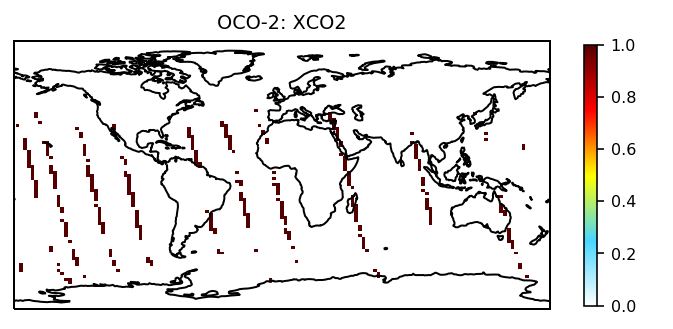

In [30]:
# plot after mapping
fig = plt.figure(figsize=[6, 6])
proj=ccrs.PlateCarree()

ax = plt.subplot(111, projection=proj)
ax.coastlines()
#tmp = oco2['psurf'] - oco2['xco2']
oco2['operation_mode'].isel(date=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=WhGrYlRd, cbar_kwargs={'shrink': 0.4, 'label': ' '})

ax.set_title('OCO-2: XCO2');

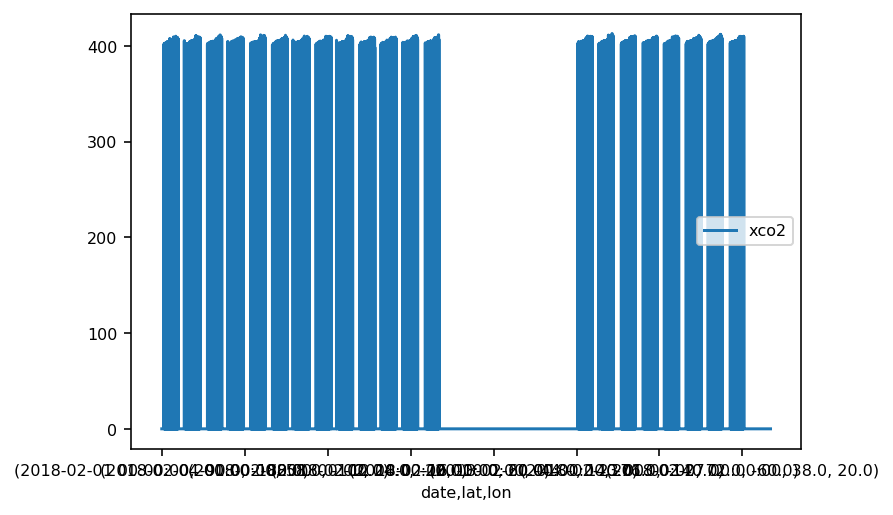

In [31]:
tmp = oco2.xco2.to_dataframe()
len(tmp)
tmp.plot()

In [32]:
oco2.to_netcdf(output_file)